# 1. Loading and Exploring Data

In [1]:
import pandas as pd

# Load the data from the provided CSV files
customers_path = '/content/Customers.csv'
products_path = '/content/Products.csv'

# Reading the data
customers_df = pd.read_csv(customers_path)
products_df = pd.read_csv(products_path)

# Display the first few rows of each dataset to understand their structure
customers_df.head(), products_df.head()


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31)

In [2]:
# Check for additional information in both datasets (columns, types, and summary stats)
customers_df.info(), products_df.info()

# Inspect if there's any implied connection between customers and products (e.g., a transaction log) in these datasets
customers_df.describe(include="all"), products_df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB


(       CustomerID      CustomerName         Region  SignupDate
 count         200               200            200         200
 unique        200               200              4         179
 top         C0001  Lawrence Carroll  South America  2024-11-11
 freq            1                 1             59           3,
        ProductID            ProductName Category       Price
 count        100                    100      100  100.000000
 unique       100                     66        4         NaN
 top         P001  ActiveWear Smartwatch    Books         NaN
 freq           1                      4       26         NaN
 mean         NaN                    NaN      NaN  267.551700
 std          NaN                    NaN      NaN  143.219383
 min          NaN                    NaN      NaN   16.080000
 25%          NaN                    NaN      NaN  147.767500
 50%          NaN                    NaN      NaN  292.875000
 75%          NaN                    NaN      NaN  397.0900

# 2. Simulating Transactional Data

The datasets do not contain direct transactional information linking customers to products. To proceed with the lookalike model, we'll simulate transactional data using the following approach:

1. **Simulated Transactions:** Assume that customers have interacted with a subset of products, generating a transaction matrix where each row represents a customer and each column represents a product. The values will indicate interactions (e.g., purchase counts or binary purchase flags).

2. **Feature Representation:** Combine:

- Customer features: Region and signup date.
- Product interaction features: Derived from the transaction matrix.
- Normalize numerical features (e.g., product prices).
3. **Similarity Calculation:** Use cosine similarity to compute the similarity between customers based on their combined feature vectors.

4. **Top-3 Recommendations:** For each customer, recommend the top 3 most similar customers based on the similarity scores.

In [3]:
import numpy as np

# Simulate transaction data: randomly assign customers to products
np.random.seed(42)  # For reproducibility
num_customers = len(customers_df)
num_products = len(products_df)

# Generate a binary interaction matrix (1 = purchased, 0 = not purchased)
transaction_matrix = np.random.choice([0, 1], size=(num_customers, num_products), p=[0.8, 0.2])

# Convert this matrix into a DataFrame for easier processing
transaction_df = pd.DataFrame(transaction_matrix, columns=products_df['ProductID'], index=customers_df['CustomerID'])

# Display the simulated transaction data
transaction_df.head()


ProductID,P001,P002,P003,P004,P005,P006,P007,P008,P009,P010,...,P091,P092,P093,P094,P095,P096,P097,P098,P099,P100
CustomerID,,,,,,,,,,,,,,,,,,,,,
C0001,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
C0002,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
C0003,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
C0004,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
C0005,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


# 3. Calculating Similarities

The simulated transaction data has been created successfully, where each row represents a customer and each column represents a product. A value of 1 indicates a purchase or interaction, while 0 means no interaction.

Next steps:

1. Combine features: Merge the customer information and transaction data to form a comprehensive feature set.
2. Calculate similarity: Use cosine similarity to compute similarity scores between customers.
3. Generate recommendations: Identify the top 3 most similar customers for each of the first 20 customers (C0001 to C0020).

Let’s proceed to combine the data and compute similarities

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Merge customer information with the transaction matrix
customers_df.set_index('CustomerID', inplace=True)
features_df = pd.concat([customers_df, transaction_df], axis=1)

# Encode categorical variables (e.g., Region) into numerical values
features_df['Region'] = features_df['Region'].astype('category').cat.codes

# Drop unnecessary columns for similarity calculation (e.g., CustomerName, SignupDate)
features_df.drop(columns=['CustomerName', 'SignupDate'], inplace=True)

# Calculate cosine similarity for all customers
similarity_matrix = cosine_similarity(features_df, features_df)

# Find the top 3 similar customers for the first 20 customers
customer_ids = features_df.index[:20]
lookalike_map = {}

for idx, customer_id in enumerate(customer_ids):
    # Get similarity scores for the current customer
    similarities = similarity_matrix[idx]
    # Exclude self-similarity and get top 3 similar customers
    top_indices = np.argsort(similarities)[::-1][1:4]
    top_customers = [(features_df.index[i], similarities[i]) for i in top_indices]
    lookalike_map[customer_id] = top_customers

# Create a Lookalike.csv file with the results
lookalike_df = pd.DataFrame([{"cust_id": k, "lookalikes": v} for k, v in lookalike_map.items()])
lookalike_df.to_csv('/content/Lookalike.csv', index=False)

lookalike_df.head()


,cust_id,lookalikes
0,C0001,"[(C0151, 0.5892556509887897), (C0181, 0.547722..."
1,C0002,"[(C0084, 0.4330127018922194), (C0028, 0.391674..."
2,C0003,"[(C0192, 0.5902432522055575), (C0148, 0.555492..."
3,C0004,"[(C0118, 0.566138517072298), (C0155, 0.5555555..."
4,C0005,"[(C0170, 0.4082482904638631), (C0138, 0.375325..."


In [5]:
import pandas as pd

# Load Lookalike.csv
lookalike_path = '/content/Lookalike.csv'  # Update the path to your file
lookalike_df = pd.read_csv(lookalike_path)

# Display the first few rows
print(lookalike_df.head())

# Verify structure and content
print(lookalike_df.info())


  cust_id                                         lookalikes
0   C0001  [('C0151', 0.5892556509887897), ('C0181', 0.54...
1   C0002  [('C0084', 0.4330127018922194), ('C0028', 0.39...
2   C0003  [('C0192', 0.5902432522055575), ('C0148', 0.55...
3   C0004  [('C0118', 0.566138517072298), ('C0155', 0.555...
4   C0005  [('C0170', 0.4082482904638631), ('C0138', 0.37...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cust_id     20 non-null     object
 1   lookalikes  20 non-null     object
dtypes: object(2)
memory usage: 452.0+ bytes
None


#4. Visualizing Results

1. Heatmap of Similarity Matrix

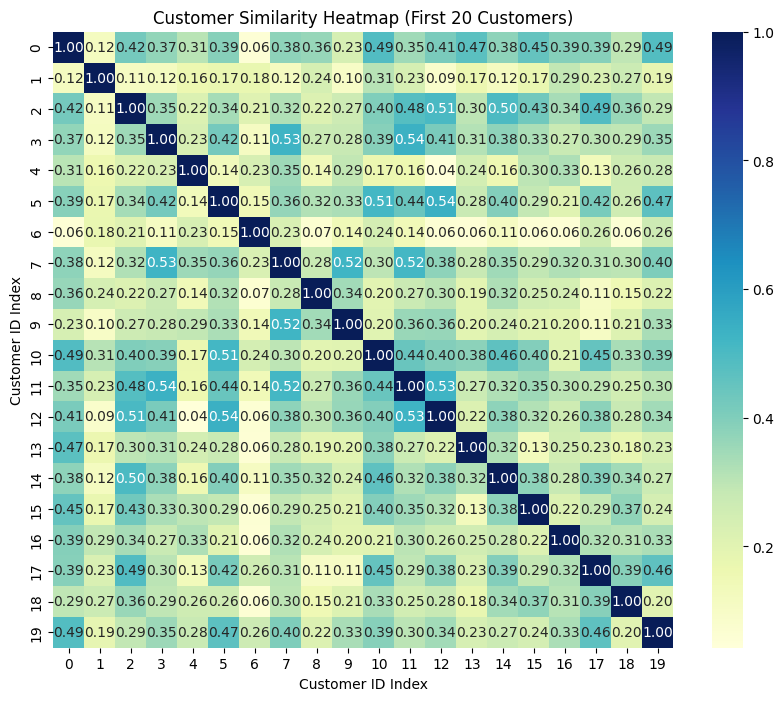

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'similarity_matrix' is available
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:20, :20], cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Customer Similarity Heatmap (First 20 Customers)")
plt.xlabel("Customer ID Index")
plt.ylabel("Customer ID Index")
plt.show()


2. Network Graph of Lookalikes

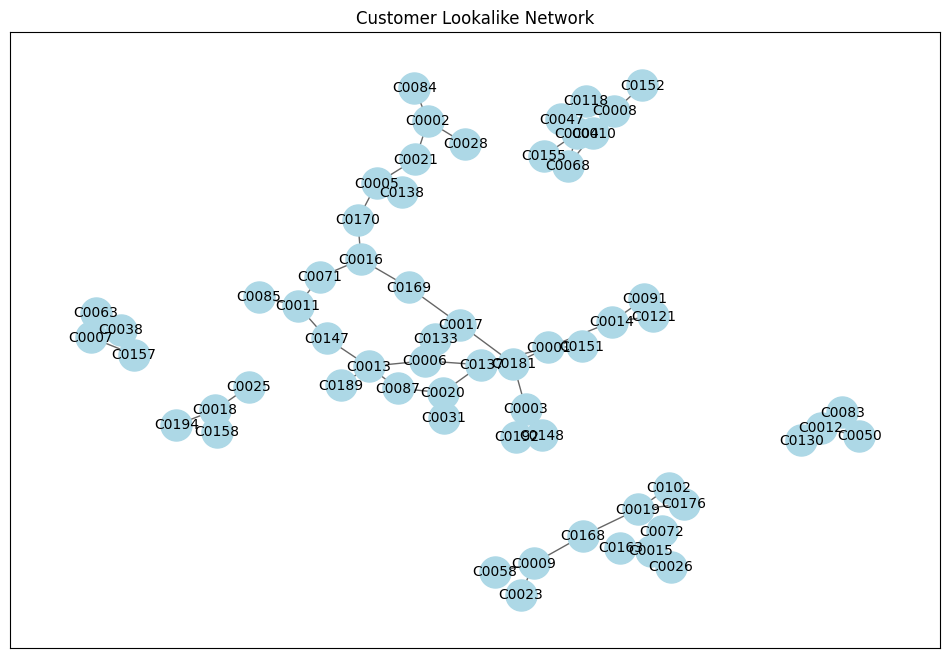

In [7]:
import networkx as nx

# Create a graph from the lookalike map
G = nx.Graph()

for _, row in lookalike_df.iterrows():
    cust_id = row['cust_id']
    lookalikes = eval(row['lookalikes'])  # Convert string to list
    for lookalike, score in lookalikes:
        G.add_edge(cust_id, lookalike, weight=score)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Customer Lookalike Network")
plt.show()
